# Analyzing Recycling Habits of UW-Madison via Oscar Sort
By Ben Schweitzer

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import pearsonr
import seaborn as sns
import statsmodels.api as sm
from mlxtend.frequent_patterns import apriori, association_rules
from ipywidgets import interact
from IPython.display import display, Markdown

### Table of Contents

* **The Data**
    * Columns
        * Date
        * Device
        * Bin
        * Item
        * Disposals
        * Contaminants
        * Correct Bin
* **Analysis & Visualization**
    * Disposals Over Time
        * Correctness Over Time
        * Item-Level Correctness
        * Device-Level Disposals and Correctmess
        * Union South Audit Comparison
        * Item + Overall correctness Correlation
        * Disposal Confusion Matrix
        * Item Association Rule Mining

## The Data
The data used in this notebook was supplied by Intuitive AI, the company that developed Oscar Sort. Oscar Sort is a smart recycling assistant that uses computer vision to identify items in the view of its camera and inform the user as to if that item is garbage or recycling. Thanks to this technology, the machine is able to identify the items being disposed of in its bin as well as what item the bin was placed in and if the item is or is not recyclable. There are four of these devices at various locations on UW-Madison's campus managed by the Office of Sustainability. The data below has been collected from all four of these on-campus machines over the course of the beginning of 2025. Each row of this data tells us how many times each item was disposed of in each bin (garbage or recycling) on each day (that data was recorded) at each location.

In [23]:
# Import the data
disposals = pd.read_csv('disposal_csv-uwisconsin(in).csv')

# Change device names to be more readable
device_location_map = {
    'uwisconsin_madison_oscarsort_1': 'U South',
    'uwisconsin_madison_oscarsort_2': 'Dejope',
    'uwisconsin_madison_oscarsort_3': 'Mem U',
    'uwisconsin_madison_oscarsort_4': 'Gordon Dining'
}
disposals['Device'] = disposals['Device'].map(device_location_map)


disposals.head()

,Date,Device,Bin,Item,Disposals,Contaminants,Correct Bin
0,1/7/2025,U South,Trash,plastic gloves,2,0,Trash
1,1/7/2025,Dejope,Trash,apple core,1,0,Trash
2,1/7/2025,Mem U,Trash,plastic wrap,1,0,Trash
3,1/14/2025,U South,Recycling,tetrapack,1,1,Trash
4,1/14/2025,U South,Recycling,wrapper,1,1,Trash


In [24]:
print(disposals.shape)

(2504, 7)


The data consists of 7 columns and 2504 rows

### Columns



In [25]:
column_names = disposals.columns
print(column_names)

Index(['Date', 'Device', 'Bin', 'Item', 'Disposals', 'Contaminants',
       'Correct Bin'],
      dtype='object')


#### Date
The day that the disposal(s) took place

In [26]:
date_min = disposals['Date'].min()
date_max = disposals['Date'].max()
print(date_min, date_max)

1/14/2025 4/8/2025


The dates covered by the data span from January 14 to April 8 of 2025

#### Device
The Oscar device that the disposal(s) was made in
(1: U South, 2: Dejope, 3: Mem U, 4: Gordon Dining)

In [27]:
print(disposals['Device'].unique())

['U South' 'Dejope' 'Mem U' 'Gordon Dining']


#### Bin
The bin that the disposal was placed in

In [28]:
print(disposals['Bin'].unique())

['Trash' 'Recycling']


#### Item
The type of item that was disposed of

The items listed below are the items labeled as **trash** by the Office of Sustainability

In [29]:
trash_items = disposals[disposals['Correct Bin'] == 'Trash']['Item'].unique()
print(trash_items)

['plastic gloves' 'apple core' 'plastic wrap' 'tetrapack' 'wrapper'
 'plastic cutlery' 'food box' 'napkin' 'plastic bag' 'coffee cup lid'
 'plastic sauce cup' 'plastic straw' 'chopsticks' 'food scraps'
 'soft plastic lid' 'liquids' 'banana peel' 'paper bowl' 'orange peel'
 'waxed food paper' 'face mask' 'stirstick' 'paper plate' 'chip bag'
 'paper plastic bag' 'receipt' 'sauce packet' 'coffee creamer cup'
 'paper lid' 'pizza box' 'paper sauce cup' 'battery' 'wooden cutlery'
 'tea bag' 'apple scraps' 'juice pouch']


The items listed below are the items labeled as **recycling** by the Office of Sustainability

In [30]:
recycling_items = disposals[disposals['Correct Bin'] == 'Recycling']['Item'].unique()
print(recycling_items)

['plastic bottle' 'plastic lid' 'plastic container' 'coffee cup'
 'plastic cup' 'coffee cup sleeve' 'paper wrapper' 'paper' 'aluminium can'
 'paper pop cup' 'paper bag' 'cardboard' 'yoghurt container'
 'aluminium foil' 'aluminium container' 'glass bottle' 'aluminium bottle'
 'paper drink tray' 'magazine']


#### Disposals
The number of times that item was disposed in that device's bin on that date

In [31]:
print(disposals['Disposals'].min(), disposals['Disposals'].mean(), disposals['Disposals'].max())
print(disposals['Disposals'].sum())

1 4.378194888178914 67
10963


The number of disposals ranges from 1 to 67 and has a mean values of about 4.38

#### Contaminants
If the item was placed in the right bin, contaminants = 0. If placed in the wrong bin, contaminants = disposals. This column exists for ease of analysis.

In [32]:
print(disposals['Contaminants'].min(), disposals['Contaminants'].mean(), disposals['Contaminants'].max())

0 1.4404952076677315 47


The number of contaminants ranges from 0 to 47 with a mean of about 1.44

#### Correct Bin
The bin (trash or recycling) that the given item should be placed in

In [33]:
print(disposals['Correct Bin'].unique())

['Trash' 'Recycling']


## Analysis and Visualization

### Disposals Over Time

Let's start by taking a look at the trends in the number of disposals made over time

<Axes: title={'center': 'Total Disposals Per Day'}, xlabel='Date'>

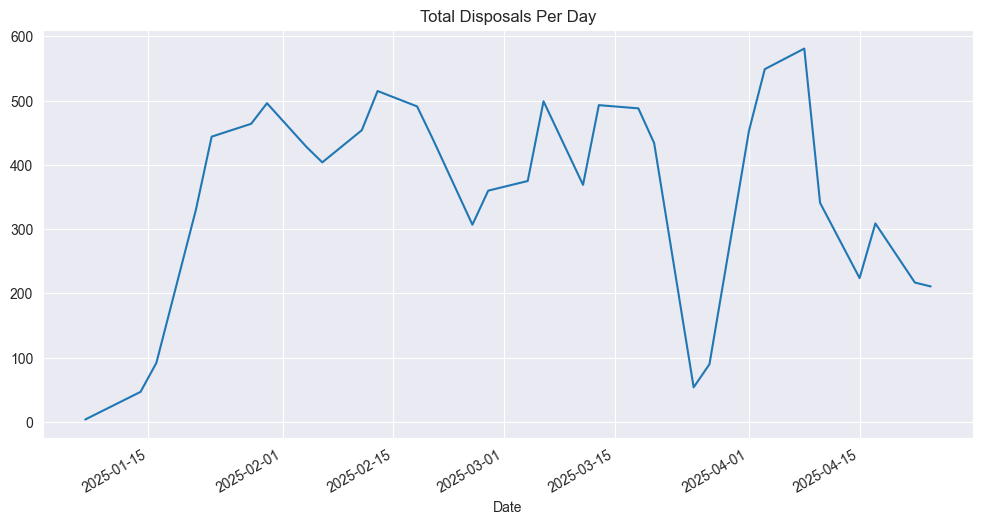

In [34]:
disposals['Date'] = pd.to_datetime(disposals['Date'])

total_disposals_per_day = disposals.groupby('Date')['Disposals'].sum()
total_disposals_per_day.plot(kind='line', figsize=(12, 6), title='Total Disposals Per Day')

We can see in the plot above that, while school is in session, the number of disposals per day hovers between 350 and 500 for the most part. The major decline at the end of March is due to Spring break (much fewer people on campus during that time).

Next, let's compare these trends to the trends in the number of contaminants per day over time.
* Note: any time contaminations are mentioned in this notebook, it refers to the number/ percentage of items that were placed in the wrong bin. In other words, it accounts for garbage placed in recycling bins and recycling placed in garbage bins.
* Any time that correctness is mentioned, it is referring to the percentage of disposals that are placed in their correct bin (garbage or recycling). This notebook is analyzing the performance of humans who are sorting their own waste. The Oscar devices prompt the user as to where to place their waste but they do not sort the wast for you.

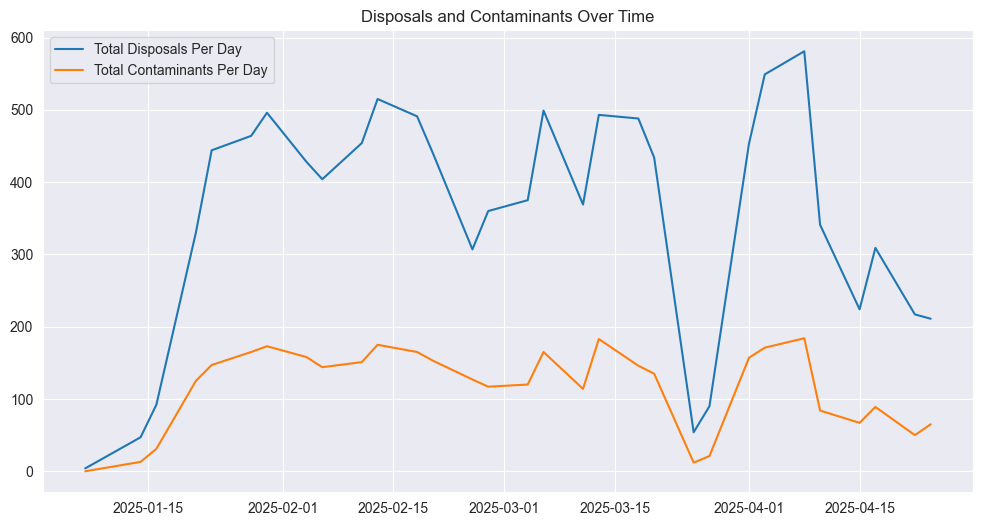

In [35]:
plt.figure(figsize=(12, 6))
total_contaminants_per_day = disposals.groupby('Date')['Contaminants'].sum()

plt.plot(total_disposals_per_day.index, total_disposals_per_day.values, label='Total Disposals Per Day')
plt.plot(total_contaminants_per_day.index, total_contaminants_per_day.values, label='Total Contaminants Per Day')
plt.title('Disposals and Contaminants Over Time')
plt.legend()
plt.show()

We can see a clear similarity in the shape of the two curves. This makes sense as the number of contaminants will always be proportional to the number of total disposals. The number of contaminants per day hovers between 100 and 200 while school is in session.

### correctness Over Time

Next, let's take a look at some of the trends in the correctness rate over time. In this case, correctness is defined as the percentage of all disposals that were placed in their correct bin.

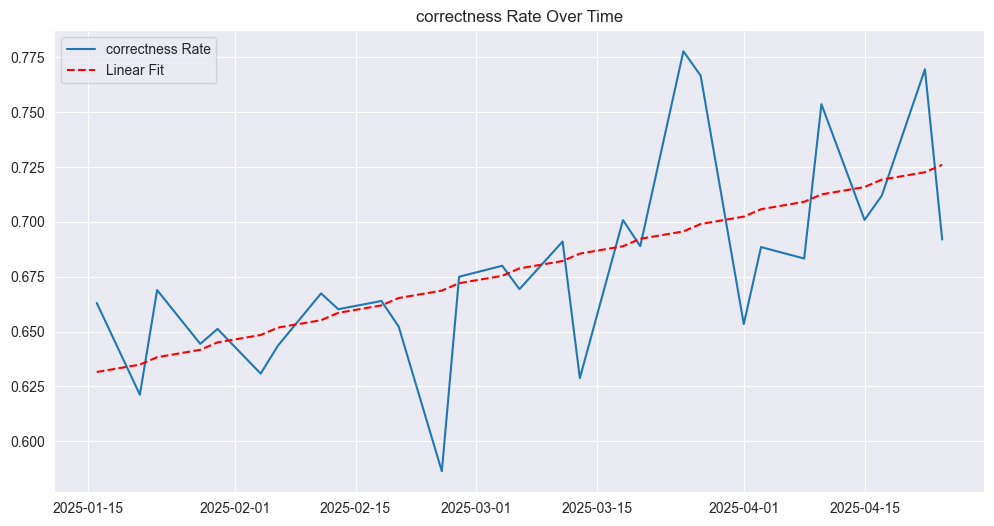

In [36]:
correctness_rate_per_day = 1 - ((total_contaminants_per_day / total_disposals_per_day))

N = 2

x = np.arange(len(correctness_rate_per_day))[N:]
y = correctness_rate_per_day.values[N:]

slope, intercept = np.polyfit(x, y, 1)
trend = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(correctness_rate_per_day.index[N:], y, label='correctness Rate')
plt.plot(correctness_rate_per_day.index[N:], trend, color='red', linestyle='--', label='Linear Fit')
plt.title('correctness Rate Over Time')
plt.legend()
plt.show()

This plot shows the promising signs of a steadily rising correctness rate when we plot the linear fit line of the correctness rate over time. The optimistic explanation for this is that as those who interact with the Oscar Sort devices interact with them again and again over time and with different items, they learn more about which items belong in which bins. This is the goal of the Oscar Sort machines, so hopefully we can see the continuation of this trend going forward and continue to move towards a more sustainable campus.

Let's break this correctness plot into trash and recycling in order to see how the two categories compare.

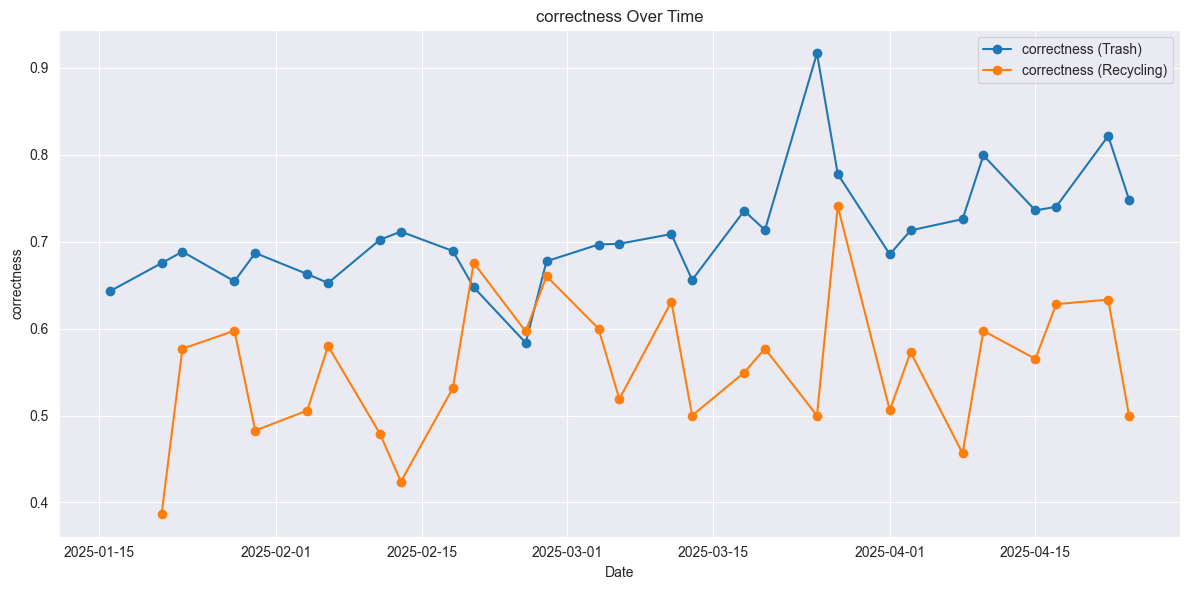

Mean trash correctness:  0.7085595370156387
Mean recycling correctness:  0.5562203371246486


In [37]:
disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Bin']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate correctness
daily['correctness'] = 1 - (daily['Contaminants'] / daily['Disposals'])

daily = daily[4:] #Cut off early values where disposal volume was low

daily_garbage = daily[daily['Bin'] == 'Trash']
daily_recycling = daily[daily['Bin'] == 'Recycling']

plt.figure(figsize=(12, 6))
plt.plot(daily_garbage['Date'], daily_garbage['correctness'], marker='o', label='correctness (Trash)')
plt.plot(daily_recycling['Date'], daily_recycling['correctness'], marker='o', label='correctness (Recycling)')
plt.title('correctness Over Time')
plt.xlabel('Date')
plt.ylabel('correctness')
plt.legend()
plt.tight_layout()
plt.show()

print('Mean trash correctness: ', daily_garbage['correctness'].mean())
print('Mean recycling correctness: ', daily_recycling['correctness'].mean())

This plot reveals that the correctness of disposals made into the trash bin has almost always exceeded that of disposals made into the recycling. Trash has a mean correctness of about 71% while recycling trails behind with an average of about 56%. This suggests that recycling should be the focus of efforts to improve waste sorting in order to improve the overall disposal correctness rate on campus.

Finally, let's see how correctness trends differ between the four different Oscar Sort devices located around campus.

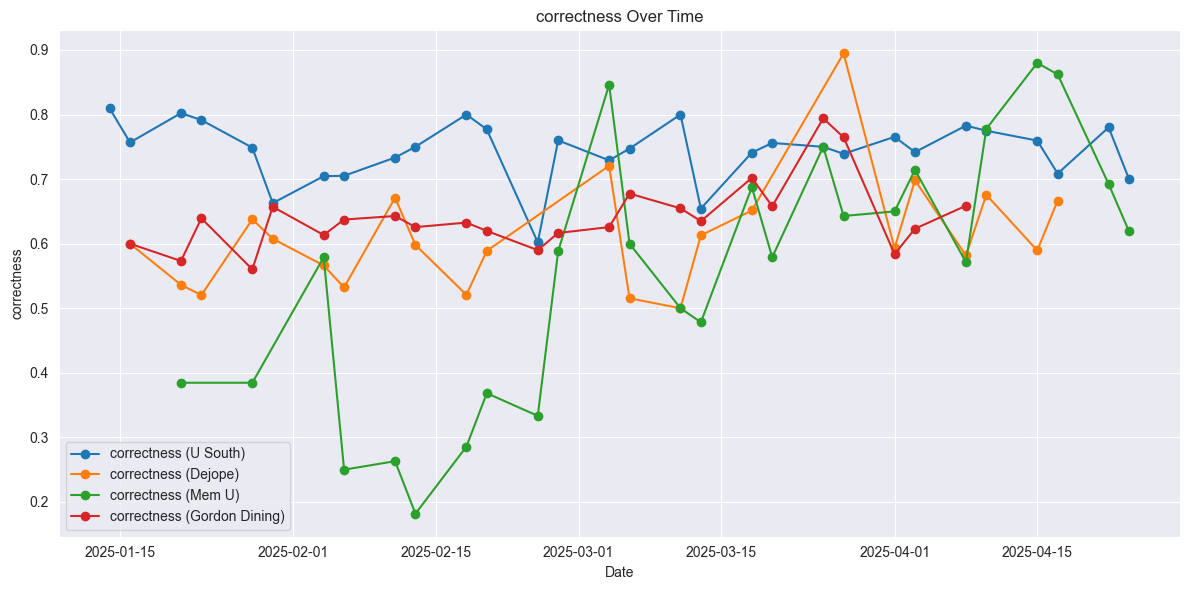

The above plot is hard to decipher due to the heavy overlap between plot lines. The plot below makes it easier to comprehend by smoothing out the lines using a rolling average

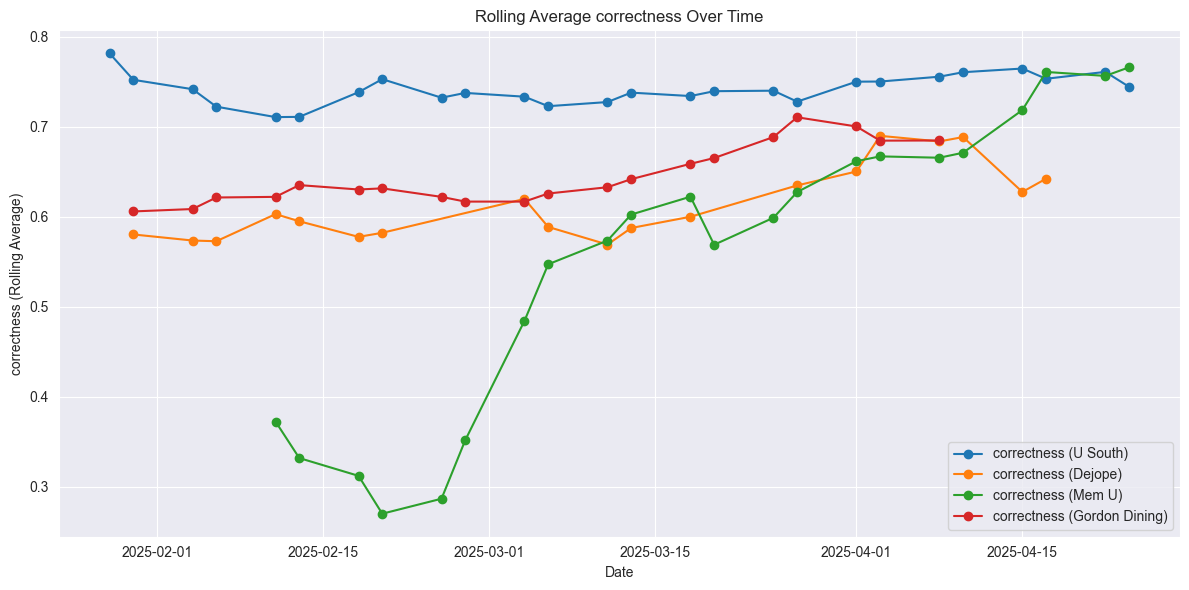

In [38]:
# correctness over time by location

disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Device']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate correctness
daily['correctness'] = 1 - (daily['Contaminants'] / daily['Disposals'])

daily = daily[4:]

devices = disposals['Device'].unique()

plt.figure(figsize=(12, 6))

for device in devices:
    daily_device = daily[daily['Device'] == device]
    plt.plot(daily_device['Date'], daily_device['correctness'], marker='o', label=f'correctness ({device})')

plt.title('correctness Over Time')
plt.xlabel('Date')
plt.ylabel('correctness')
plt.legend()
plt.tight_layout()
plt.show()

display(Markdown(("The above plot is hard to decipher due to the heavy overlap between plot lines. The plot below makes it easier to comprehend by smoothing out the lines using a rolling average")))

# Let's make the plot a lot easier to read by smoothing out the lines in the plot

plt.figure(figsize=(12, 6))

for device in devices:
    daily_device = daily[daily['Device'] == device]
    # Applies a rolling average to the y values in order to make the visualization more readable
    smoothed_correctness = daily_device['correctness'].rolling(window=5).mean()
    plt.plot(daily_device['Date'], smoothed_correctness, marker='o', label=f'correctness ({device})')

plt.title('Rolling Average correctness Over Time')
plt.xlabel('Date')
plt.ylabel('correctness (Rolling Average)')
plt.legend()
plt.tight_layout()
plt.show()

From this visual we can reason that the device located in Union South sees the most accurate disposals on average amongst all devices. As we will see later, the device in Memorial Union sees a considerably lower amount of disposals, which is likely the cause for the much more volatile correctness rate. Dejope and Gordon's see similar performance over time, but are still underperforming Union South on average. This disparity may be a result of dining halls being located in Dejope and Gordon's while there is no dining hall in U South.

### Item-Level Accuracies

Let's now take a look at some item-by-item statistics. We can start by looking at what the top 5 most dispossed of items are across all devices and dates.

In [39]:
item_freqs = disposals.groupby(['Item', 'Correct Bin'])['Disposals'].sum()
item_freqs_df = item_freqs.sort_values(ascending=False).head(5).to_frame()
total_disposals = item_freqs.sum()
item_freqs_df['Percentage Of Total Disposals'] = (item_freqs_df['Disposals'] / total_disposals * 100).round(2)
display(item_freqs_df.head(5))

,,Disposals,Percentage Of Total Disposals
Item,Correct Bin,,
napkin,Trash,2302,21.00
plastic cutlery,Trash,1201,10.96
plastic container,Recycling,1192,10.87
food box,Trash,756,6.90
wrapper,Trash,752,6.86


Considering that all four devices on campus are located near food and beverage sellers such as dining halls and convenience stores, it is no surprise that the top 5 most disposed of items are all food related. The counter-service restaurants and stores located near these machines sell many of their offerings in plastic containers or boxes and have napkins and plastic cutlery available for people to use. Therefore, we can conclude that these restaurants and stores are the source of the majority of the waste disposed of in these device and at these locations in general.

Now let's take a look at which items wind up as contaminants most frequently.

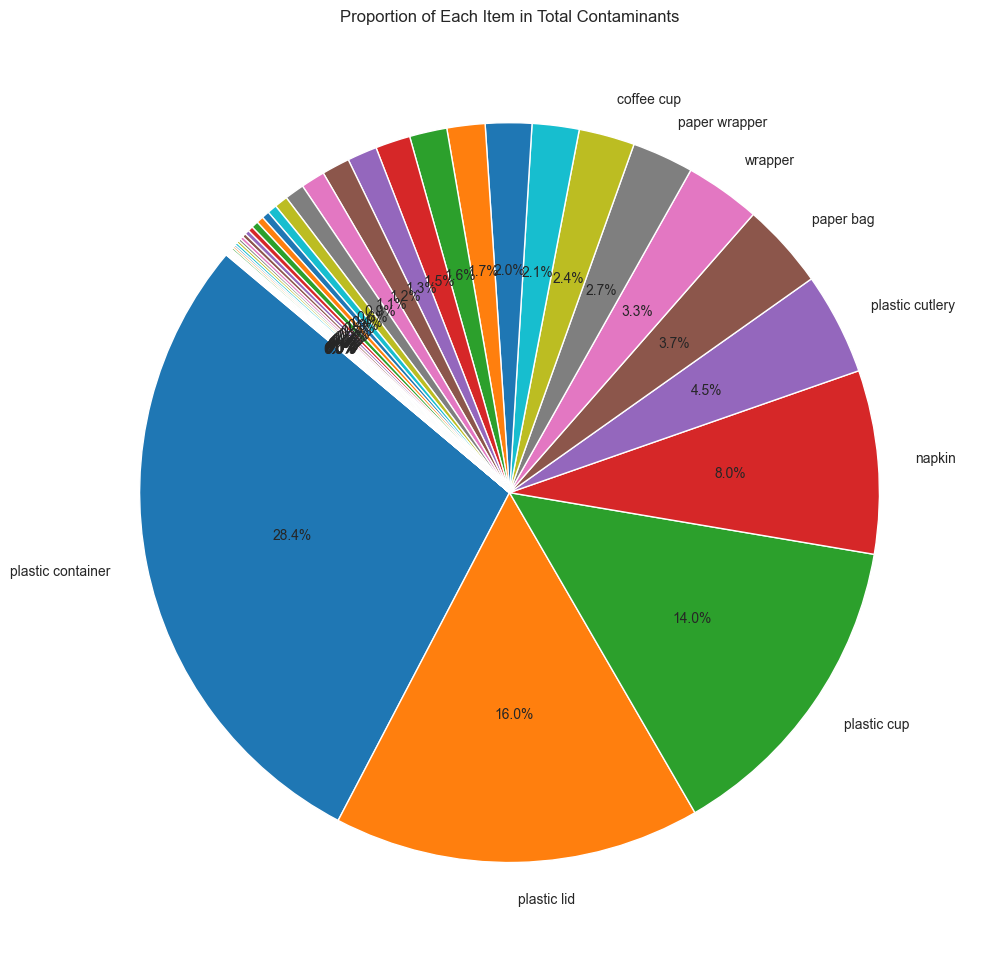

In [40]:
contaminants_by_item = disposals.groupby('Item')['Contaminants'].sum()
# Filter out items with zero contaminants (optional)
contaminants_by_item = contaminants_by_item[contaminants_by_item > 0]
contaminants_by_item = contaminants_by_item.sort_values(ascending=False)

labels = [item if value > 80 else '' for item, value in contaminants_by_item.items()]

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(contaminants_by_item, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Item in Total Contaminants')
plt.tight_layout()
plt.show()

The above pie chart reveals to us that plastic containers, lids, and cups make up more than half of the total contaminants recorded in this data. Additionally, these items are all recyclable. This shows us that the biggest waste sorting concern for these locations is the failure to recycle plastic food and beverage containers. Taking action to address this issue could have a major impact on the overall disposal correctness.

Let's list and visualize the contamination percentages of each item to see which items have been the hardest to sort correctly. _Please note that some items have a very low volume of disposals which can result in contamination percentages near 100% or 0%._

Item Contaminant Percentages:
Item                 Correct Bin
paper drink tray     Recycling      100.000000
glass bottle         Recycling      100.000000
aluminium foil       Recycling       91.666667
paper bag            Recycling       87.662338
plastic container    Recycling       86.073826
paper pop cup        Recycling       84.615385
plastic lid          Recycling       79.724138
paper wrapper        Recycling       76.984127
plastic cup          Recycling       74.777448
coffee cup sleeve    Recycling       69.767442
yoghurt container    Recycling       66.666667
tetrapack            Trash           53.846154
aluminium container  Recycling       50.000000
paper                Recycling       48.366013
coffee cup           Recycling       46.560847
plastic bottle       Recycling       26.818182
aluminium bottle     Recycling       25.000000
paper plate          Trash           23.529412
cardboard            Recycling       22.857143
plastic straw        Trash           21.1594

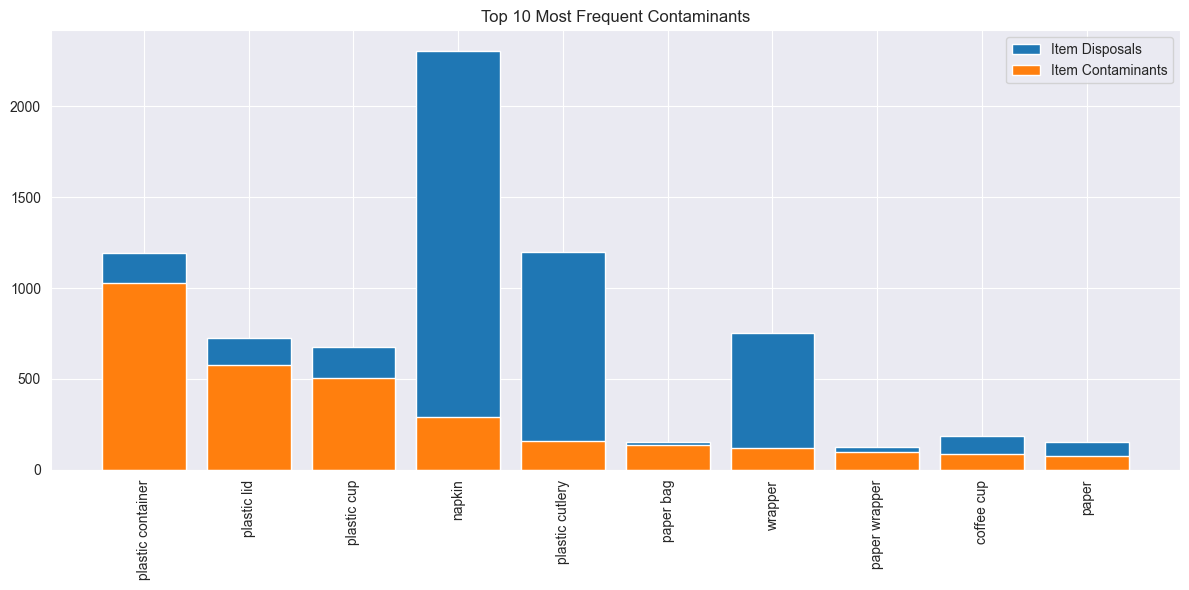

In [41]:
item_contaminant_freqs = disposals.groupby(['Item', 'Correct Bin'])['Contaminants'].sum().sort_values(ascending=False)

item_contaminant_percentages = (item_contaminant_freqs / item_freqs).fillna(0) * 100
item_contaminant_percentages = item_contaminant_percentages.sort_values(ascending=False)

print("Item Contaminant Percentages:")
print(item_contaminant_percentages)

sorted_items = item_contaminant_freqs.index[:10]

# 2. Reindex both frequencies by this sorted order
item_disposals_sorted = item_freqs.reindex(sorted_items, fill_value=0)
item_contaminants_sorted = item_contaminant_freqs.reindex(sorted_items, fill_value=0)

# 3. Plot using the sorted order
plt.figure(figsize=(12, 6))
x = np.arange(len(sorted_items))

plt.bar(x, item_disposals_sorted.values, label='Item Disposals')
plt.bar(x, item_contaminants_sorted.values, label='Item Contaminants')

plt.xticks(x, [item[0] for item in sorted_items], rotation=90)
plt.title('Top 10 Most Frequent Contaminants')
plt.legend()
plt.tight_layout()
plt.show()

The output above the graph shows the striking pattern of nearly all the items that belong in recycling have a higher contamination rate than those that belong in the trash. This is yet another indicator that recycling incorrectness is a much bigger issue than garbage incorrectness. In the box plot above, we can see yet again how the plastic food and beverage containers produce an extremely high amount of contaminants relative to all other items. This is especially concerning as plastic containers, lids, and cups are among the top seven most frequently disposed of items. On the other hand, other frequently disposed of items such as napkins and plastic cutlery, which are labeled as trash, have much lower contamination rates.

Finally, let's visualize the accuracies of each individual item and color the bars by recyclables vs trash in order to see how the two types compare. Before we do this, we want to filter out items that have extremely infrequent disposals as this will result in a meaningless correctness percentage. In order to see what the threshold should be, let's create a histogram of all item disposal totals beneath 500.

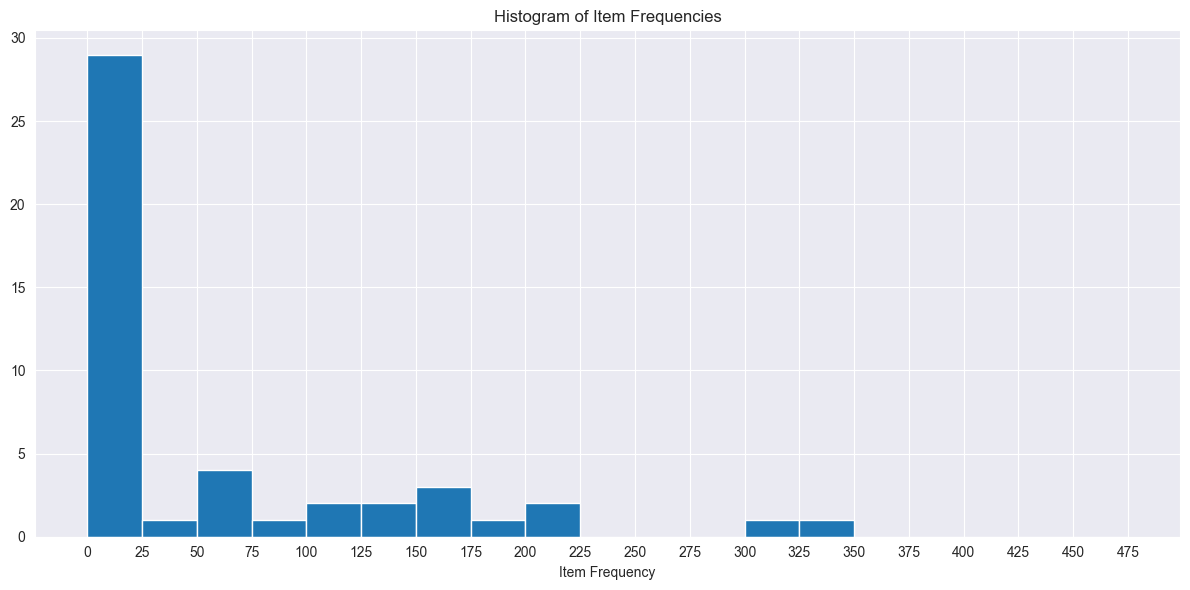

In [42]:
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(item_freqs, bins=np.arange(0, 500, 25))
plt.title('Histogram of Item Frequencies')
plt.xticks(bins)
plt.xlabel('Item Frequency')
plt.tight_layout()

We're going to set the threshold to be 25, as we don't want to consider items with a volume any lower than 25 disposals in total. This will eliminate the bottom 25-30 items.

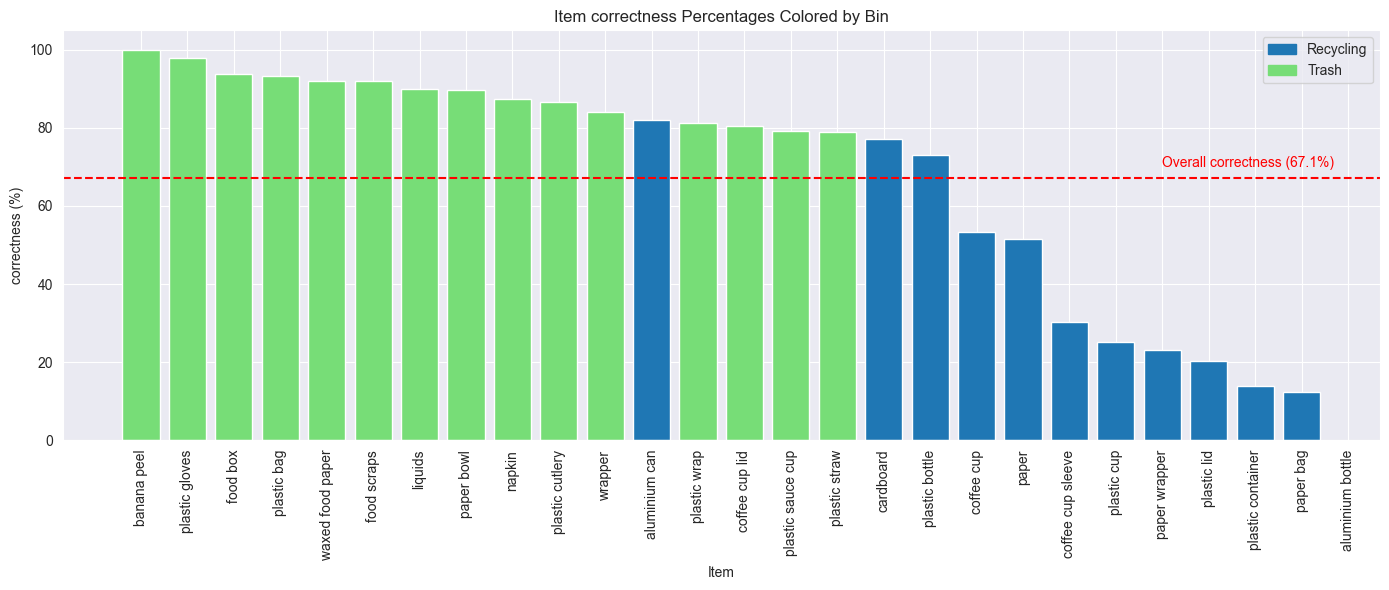

In [43]:
#Filter for the volume threshold
VOLUME_MIN = 25
item_freqs_filtered = item_freqs[item_freqs > VOLUME_MIN]

item_correctness_percentages = ((item_freqs_filtered - item_contaminant_freqs) / item_freqs_filtered * 100).sort_values(
    ascending=False).reset_index()
item_correctness_percentages.columns = ['Item', 'Correct Bin', 'correctness']


bin_colors = {'Recycling': '#1f77b4', 'Trash': '#77dd77'}
handles = [mpatches.Patch(color=color, label=bin) for bin, color in bin_colors.items()]
colors = item_correctness_percentages['Correct Bin'].map(bin_colors)

overall_correctness = ((disposals['Disposals'].sum() - disposals['Contaminants'].sum()) / disposals[
    'Disposals'].sum()) * 100

plt.figure(figsize=(14, 6))
bars = plt.bar(item_correctness_percentages['Item'], item_correctness_percentages['correctness'], color=colors)
plt.axhline(overall_correctness, color='red', linestyle='--', label=f'Overall correctness ({overall_correctness:.1f}%)')
plt.xticks(rotation=90)
plt.xlabel('Item')
plt.ylabel('correctness (%)')
plt.title('Item correctness Percentages Colored by Bin')
plt.text(22, 70, f'Overall correctness ({overall_correctness:.1f}%)', color='red')
plt.legend(handles=handles, loc='upper right')
plt.tight_layout()

This visual shows a clear distinction in the correctness rates of most recycling items and most trash items. There are 15 items whose accuracies fall beneath the mark of the overall correctness rate of all disposals. Of these 15, only 1 is a trash item; The rest are recyclables. This striking pattern is yet another sign that failure to sort recyclable items correctly is perhaps the single greatest limiter of waste sorting correctness on campus. Another concerning note is that while plastic containers are the third most disposed of item, they are also the fifth least accurately disposed of item. This high volume of contaminants is a big hit to the overall correctness rate on campus.

### Device-level Disposals and Accuracies

This next section will focus on comparing trends in each of the four different devices (each in their own location) on campus.

For starters, let's simply look at the volume of total disposals at each location.

Device
Gordon Dining    4343
U South          4317
Dejope           1812
Mem U             491
Name: Disposals, dtype: int64


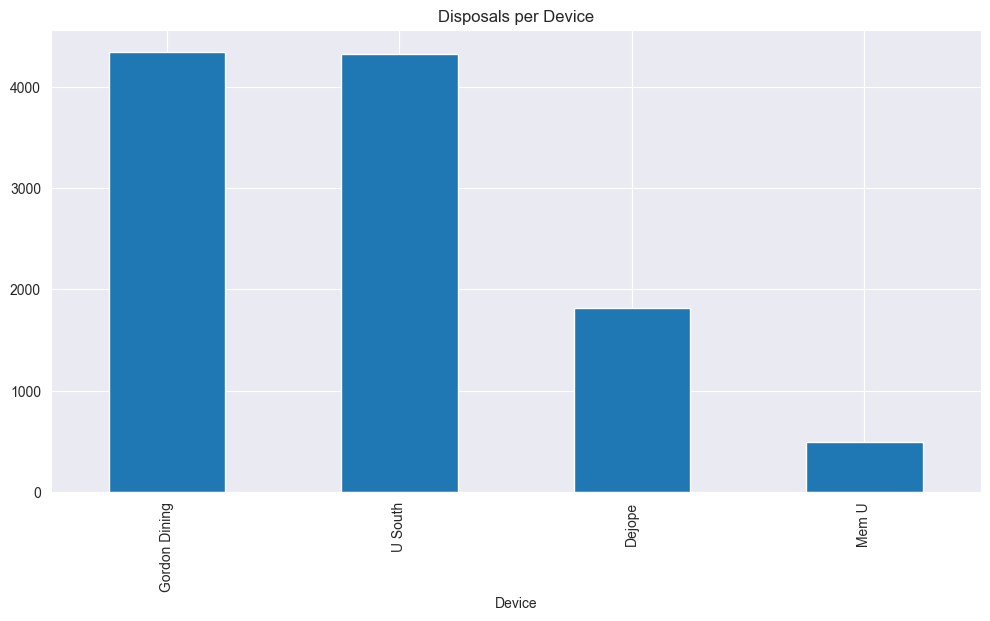

In [44]:
disposals_by_device = disposals.groupby('Device')['Disposals'].sum().sort_values(ascending=False)
disposals_by_device.plot(kind='bar', figsize=(12, 6), title='Disposals per Device')
print(disposals_by_device.head(4))

Gordon Dining and Union South see nearly identical volume while Dejope and Memorial Union see significantly less. These numbers are likely due to the physical location of each device within each building and how much foot traffic passes by each device.

As totals can sometimes be deceiving, let's next look at the rate of average disposals per day for each device.

          Device  Mean Disposals  Std Dev Disposals
3  Gordon Dining      180.958333          62.633842
2        U South      139.258065          62.138538
0         Dejope       75.500000          30.684935
1          Mem U       17.535714           9.378787


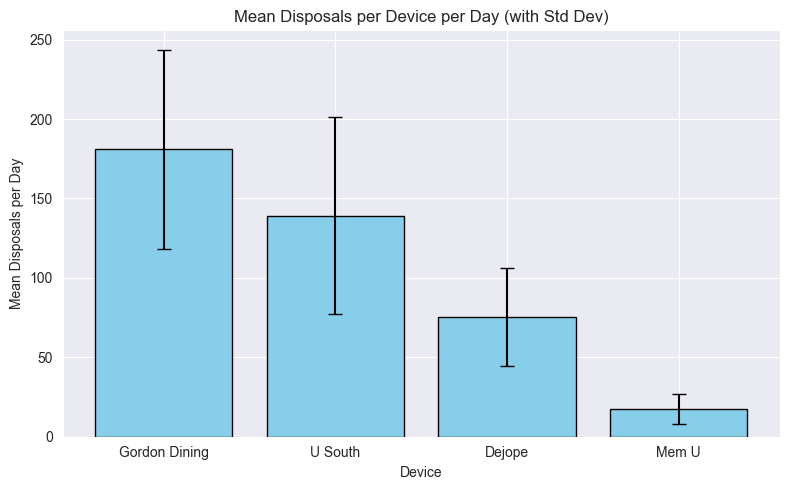

In [45]:
disposals_per_device_day = disposals.groupby(['Date', 'Device'])['Disposals'].sum().reset_index()

rows = []
for device in disposals_per_device_day['Device'].unique():
    cur = disposals_per_device_day[disposals_per_device_day['Device'] == device]
    mean = cur['Disposals'].mean()
    std = cur['Disposals'].std()
    rows.append({'Device': device, 'Mean Disposals': mean, 'Std Dev Disposals': std})

summary_table = pd.DataFrame(rows)
summary_table = summary_table.sort_values(by='Mean Disposals', ascending=False)

print(summary_table)

plt.figure(figsize=(8, 5))

x = summary_table['Device']
y = summary_table['Mean Disposals']
yerr = summary_table['Std Dev Disposals']

plt.bar(x, y, yerr=yerr, capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('Device')
plt.ylabel('Mean Disposals per Day')
plt.title('Mean Disposals per Device per Day (with Std Dev)')
plt.tight_layout()
plt.show()

While the ordering of devices by total and by rate are the same, there is a larger disparity between U South and Gordon in rate than there is in total. This tells us that perhaps these two locations are not quite as similar in foot traffic as they may appear. However, we should also consider that both these means have fairly large error.

Let's look at another comparison of disposal volumes, this time with recyclables and trash disposals seperated by correct bin.

RECYCLING TO TRASH RATIOS:

          Device  Rec to Trash Ratio
0         Dejope            0.680891
1  Gordon Dining            0.624159
2          Mem U            0.588997
3        U South            0.442848


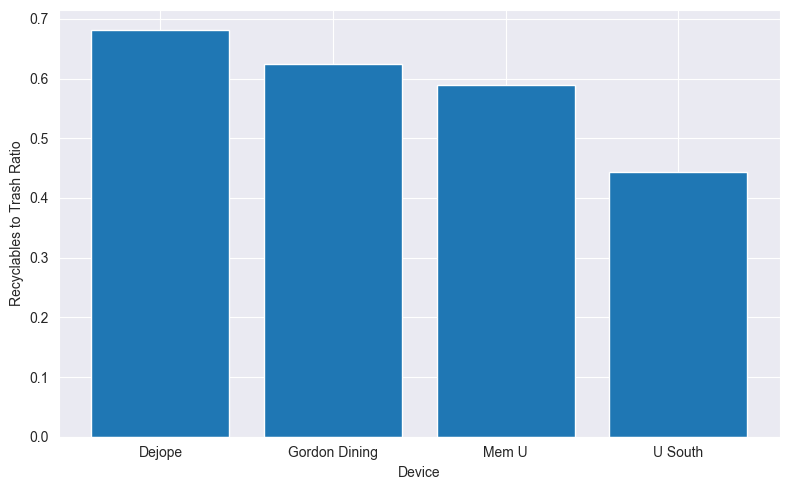

In [46]:
device_by_bin = disposals.groupby(['Device', 'Correct Bin'])['Disposals'].sum().reset_index()

print('RECYCLING TO TRASH RATIOS:\n')
rows = []
for location in device_by_bin['Device'].unique():
    cur = device_by_bin[device_by_bin['Device'] == location]

    recycling_sum = cur[cur['Correct Bin'] == 'Recycling']['Disposals'].sum()
    trash_sum = cur[cur['Correct Bin'] == 'Trash']['Disposals'].sum()
    rows.append({'Device': location, 'Rec to Trash Ratio': recycling_sum / trash_sum})

summary_table = pd.DataFrame(rows)
summary_table = summary_table.sort_values(by='Rec to Trash Ratio', ascending=False)
print(summary_table)

plt.figure(figsize=(8, 5))
plt.bar(summary_table['Device'], summary_table['Rec to Trash Ratio'])
plt.xlabel('Device')
plt.ylabel('Recyclables to Trash Ratio')
plt.tight_layout()
plt.show()

Based off this visual and table, we can see that Dejope's bins see the highest proportion of recyclable items while Gordon and Mem U lag just behind and U South has a considerably lower ratio. These differences are most likely due to the different kinds of waste being generated by the unique combination of dining halls, stores, vending machines, and other food and beverage locations located near each of the bins. These ratios will prove useful in making further locations in our next analysis where we look at the correctness of each location's disposals.

While each location

Contamination Rates:
 Device
Mem U            40.733198
Dejope           39.403974
Gordon Dining    36.587612
U South          25.573315
dtype: float64


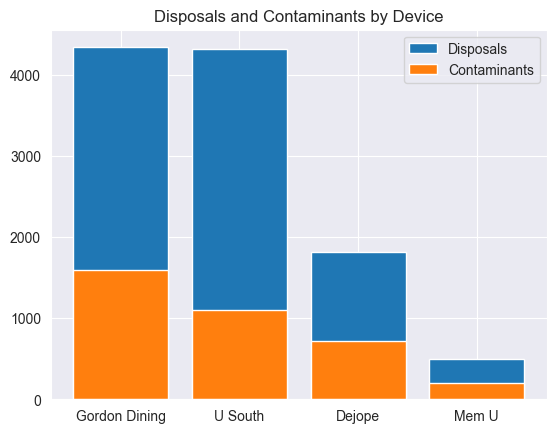

In [47]:
contaminants_by_device = disposals.groupby('Device')['Contaminants'].sum().sort_values(ascending=False)

contamination_percentage_by_device = (contaminants_by_device / disposals_by_device * 100).sort_values(ascending=False)
print('Contamination Rates:\n', contamination_percentage_by_device.head(4))

plt.bar(disposals_by_device.index, disposals_by_device.values, label='Disposals')
plt.bar(contaminants_by_device.index, contaminants_by_device.values, label='Contaminants')
plt.title('Disposals and Contaminants by Device')
plt.legend()
plt.show()

The table and visual above show similar contamination rates for all locations except for Union South. This is interesting, as although there are two Union locations with Oscar Sort machines and both contain similar food and beverage services, the contamination rates are nearly 15% different. However, Mem U also sees a nearly 15% greater proportion of recyclable items compares to Union South. Given what we know about the trend of inability to sort recycling correctly, this could play a big factor in this difference of accuracies. Additionally, U South has the lowest recycling to trash ratio of any location, providing a possible explanation for its extraordinarily low contamination rate. This begs the question, is waste sorting better at Union South better than other locations or does it just simply not see as many recyclables (proportionally)? Let's take a look at accuracies seperated by the two types of bins to answer this.

correctness Rates:



,Device,Bin,Disposals,Contaminants,correctness
7,U South,Trash,3478,755,0.782921
5,Mem U,Trash,304,88,0.710526
3,Gordon Dining,Trash,3653,1284,0.648508
1,Dejope,Trash,1516,576,0.620053
6,U South,Recycling,839,349,0.584029
2,Gordon Dining,Recycling,690,305,0.557971
0,Dejope,Recycling,296,138,0.533784
4,Mem U,Recycling,187,112,0.401070


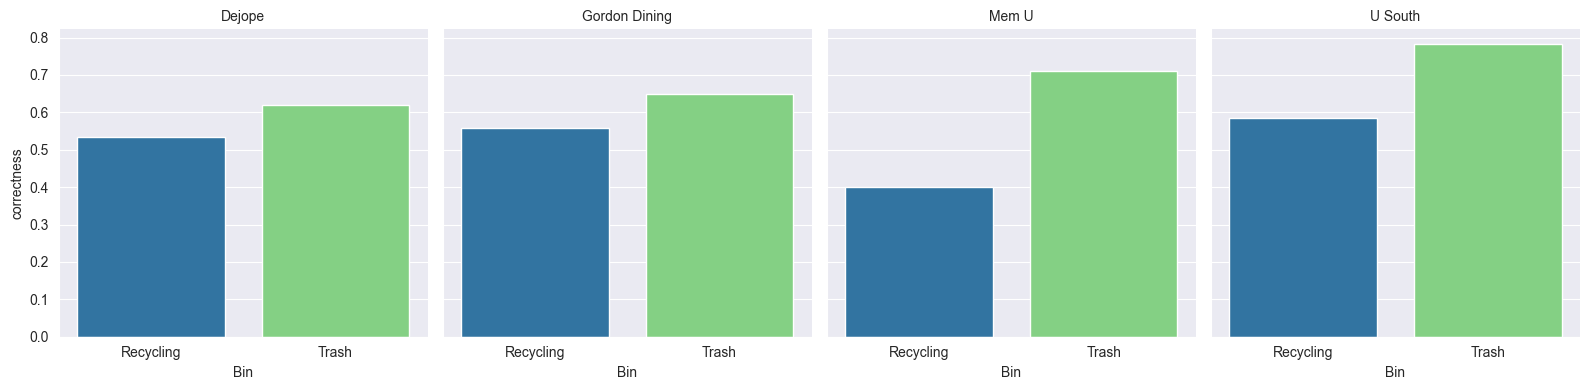

In [62]:
device_by_bin_2 = (disposals.groupby(['Device', 'Bin'])[['Disposals', 'Contaminants']].sum().reset_index())
device_by_bin_2['correctness'] = 1 - (device_by_bin_2['Contaminants'] / device_by_bin_2['Disposals'])

print('correctness Rates:\n')
display(device_by_bin_2.sort_values(by=['correctness'], ascending=False))

grid = sns.FacetGrid(device_by_bin_2, col= 'Device', col_wrap=4, height=4)

grid.map_dataframe(sns.barplot, x='Bin', y='correctness', hue = 'Bin', palette={'Recycling': '#1f77b4', 'Trash': '#77dd77'})

grid.set_titles('{col_name}')
grid.set_axis_labels('Bin', 'correctness')
plt.tight_layout()
plt.show()

The table and visual above give us our answer: **Union South has the best waste sorting** of the four Oscar Sort devices. Both the highest trash and recycling correctness rates come from this location, proving that its exceptionally low contamination rate is not skewed by a relatively high proportion of trash. Additionally, its overall contamination rate is about 8% lower than the overall contamination rate of all four devices. This analysis reveals Union South to be the highest performing location for waste sorting in Oscar Sort devices out of the four on campus. Perhaps further research into what sets Union South apart from the others could provide useful insights into how to promote similarly positive results at other Oscar Sort Devices both currently installed and even those that could be installed in the future.

### Union South Audit Comparison
This data was collected from a manual waste audit performed in December 2024. This data allows us to get a glimpse at what the state of waste sorting on campus was like before the instillation of the Oscar Sort machines. However, we must note that while Oscar Sort is not able to detect soiled recyclables (that are therefore no longer recyclable) the manual waste audit did account for this. For this reason, there may be some compound inconsistency.

In [49]:
audit = pd.read_csv('USouth_waste_audit.csv')
display(audit.head(5))

,Day,Type,Mass (lbs),Total Recyclable (lbs),Contamination Percentage
0,Tue,Garbage,363.57,16.50,4.54
1,Wed,Garbage,257.53,12.10,4.70
2,Thu,Garbage,95.15,4.30,4.52
3,Tue,Recycling,55.98,27.42,48.98
4,Wed,Recycling,16.90,11.50,68.05


Here are the numbers I was given from the audit report. We have the masses of waste audited as well as the contamination percentages for three days of garbage collection and two days of recycling collection within Union South.

In [50]:
# These numbers come directly from the waste audit report
total_usouth_recycle_contamination = 53.40
total_usouth_garbage_contamination = 4.59

These numbers above also come from the reports and are simply calculations of the overall contamination rates from all three days of garbage collection and both days of recycling collection. Let us create a table and a visual that shows contamination percentages from both the audit and the Oscar device at Union South in order to compare the two.

In [51]:
usouth = disposals[disposals['Device'] == 'U South']

contamination_by_bin = (usouth.groupby('Bin')['Contaminants'].sum() / usouth.groupby('Bin')['Disposals'].sum()) * 100

contamination_percentages = pd.DataFrame({
    'Type': ['Recycling', 'Garbage', 'Recycling', 'Garbage'],
    'Source': ['Audit', 'Audit', 'Device', 'Device'],
    'Contam Percentage': [53.40, 4.59, contamination_by_bin['Recycling'], contamination_by_bin['Trash']]

})

display(contamination_percentages.head())

,Type,Source,Contam Percentage
0,Recycling,Audit,53.400000
1,Garbage,Audit,4.590000
2,Recycling,Device,41.597139
3,Garbage,Device,21.707878


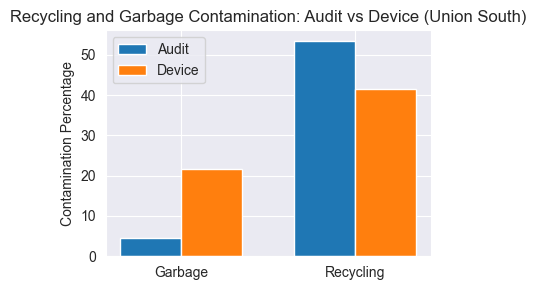

In [52]:
pivot_df = contamination_percentages.pivot(index='Type', columns='Source', values='Contam Percentage')

# Set up bar positions
types = pivot_df.index
x = np.arange(len(types))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, pivot_df['Audit'], width, label='Audit')
ax.bar(x + width/2, pivot_df['Device'], width, label='Device')

ax.set_ylabel('Contamination Percentage')
ax.set_title('Recycling and Garbage Contamination: Audit vs Device (Union South)')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend()
plt.tight_layout()
plt.show()

The above visual and table reveal that the Oscar devices record better performance in recycling sorting than the audit while the opposite is true for garbage. A possible explanation for this pattern is that the presence of the Oscar Sort device creates a behavioural shift towards recycling, and as a result, more people are using and disposing of recyclable items. This could explain the rise in recycling correctness and decrease in garbage correctness as more recyclables enter the waste stream as Oscar's are introduced.

### Item + Overall correctness Correlation
This section involves calculating the correlation of each item's correctness with the overall correctness of all disposals. In other words, how similar is the pattern of each item's correctness over time to the pattern of the total correctness over time. This will allow us to determine what items have the greatest influence on overall correctness, thus making those items the most important to sort correctly.

In [53]:
# Get daily correctness by item
item_daily = disposals.groupby(['Date', 'Item']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
item_daily['correctness'] = 1 - (item_daily['Contaminants'] / item_daily['Disposals'])

# Get daily overall correctness
daily = disposals.groupby('Date').agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
daily['correctness'] = 1 - (daily['Contaminants'] / daily['Disposals'])

correlation_results = []
# Compute correlations between item correctness and overall correctness
for item in item_daily['Item'].unique():
    item_data = item_daily[item_daily['Item'] == item]
    item_data = item_data.merge(daily[['Date', 'correctness']], on='Date', suffixes=('', '_Overall'))

    if len(item_data) >= 3 and len(item_data['correctness'].unique()) > 1:
        correlation, _ = pearsonr(item_data['correctness'], item_data['correctness_Overall'])
        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = correlation
    else:
        correlation = np.nan  # Use NaN for missing data
        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = 0

    correlation_results.append({'Item': item, 'Correlation': correlation})

#Convert results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)
display(correlation_df.sort_values(by=['Correlation'], ascending=False))


,Item,Correlation
43,aluminium bottle,0.972064
13,plastic lid,0.588598
11,plastic cup,0.499072
35,chip bag,0.449888
2,plastic wrap,0.403791
31,waxed food paper,0.400905
3,coffee cup,0.336129
21,liquids,0.327883
22,paper,0.232265
18,aluminium can,0.157449


Above is a table of the correlation scores for every item. The closer the value is to 1, the more of a positive linear correlation is present between that item's correctness and the overall correctness. The closer the values is to -1, the more of a negative linear correlation is present. A value of 0 implies no linear correlation is present. Only items with more than 2 days of recorded disposals are considered in this calculation (the rest are marked as NaN).
Let's take a look at the accuracies of each item over time compared to the overall correctness plot.

interactive(children=(Dropdown(description='x', options=('aluminium bottle', 'aluminium can', 'aluminium conta…

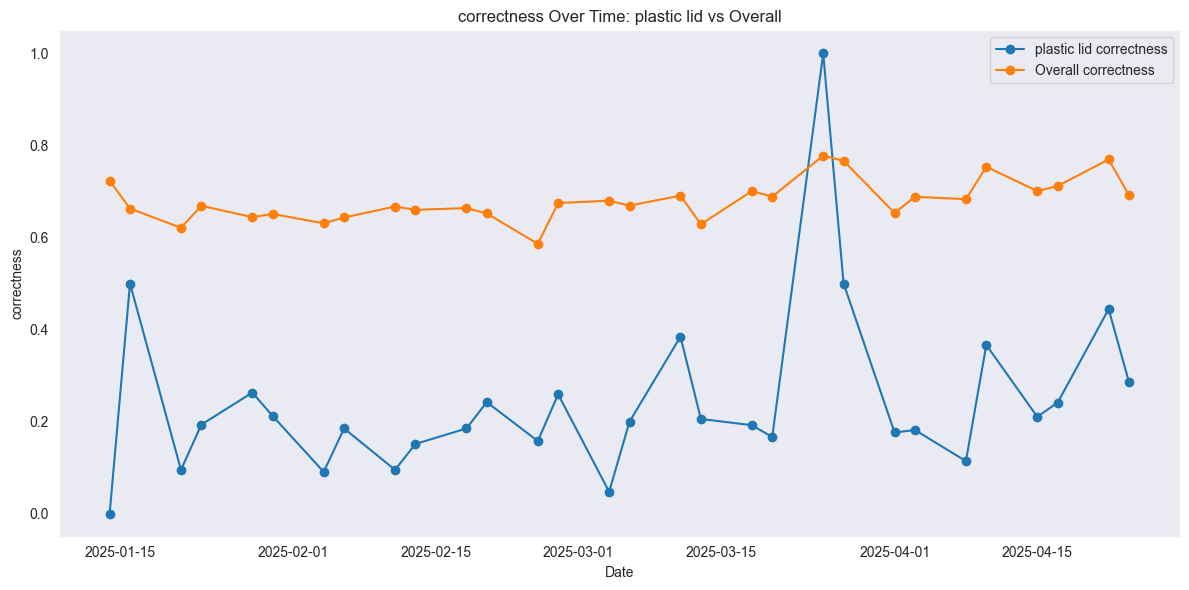

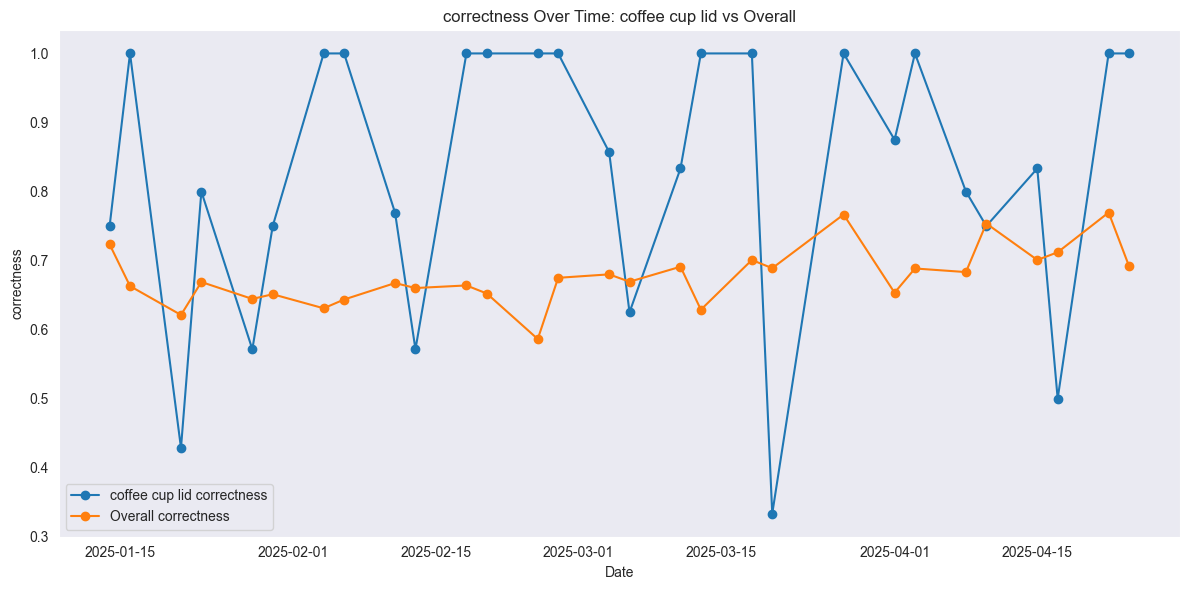

In [54]:

def f(x):
    item = x


    item_data = item_daily[item_daily['Item'] == item]
    item_data = item_data.merge(daily[['Date', 'correctness']], on='Date', suffixes=('', '_Overall'))

    plt.figure(figsize=(12, 6))
    plt.plot(item_data['Date'], item_data['correctness'], label=f'{item} correctness', marker='o')
    plt.plot(item_data['Date'], item_data['correctness_Overall'], label='Overall correctness', marker='o')
    plt.title(f'correctness Over Time: {item} vs Overall')
    plt.xlabel('Date')
    plt.ylabel('correctness')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

interact(f, x=sorted(disposals['Item'].unique()))
f('plastic lid')
f('coffee cup lid')

_Note: The visual above uses an interactive dropdown menu and may not work properly based on where this notebook is being viewed_

As we view the plots of different items, we can see the differences between high and low correlation scores in the visual. The two plots beneath the dropdown are an example of this distinct difference. The first plot of the two shows the correctness of plastic lid disposals over time compared to overall correctness. Plastic lids have a correlation score of nearly 0.6, which is relatively high. The last plot is comparing overall correctness and the correctness of coffee cup lids, which has a correlation score of only about 0.02, a value very close to 0. It is clear that there is much more similarity between the shape of the lines in the plastic lid plot than in the coffee cup lid plot. These plots demonstrate what makes for relatively high and low correlation scores.

Let's plot out all the correlation scores in order to compare all of our items.

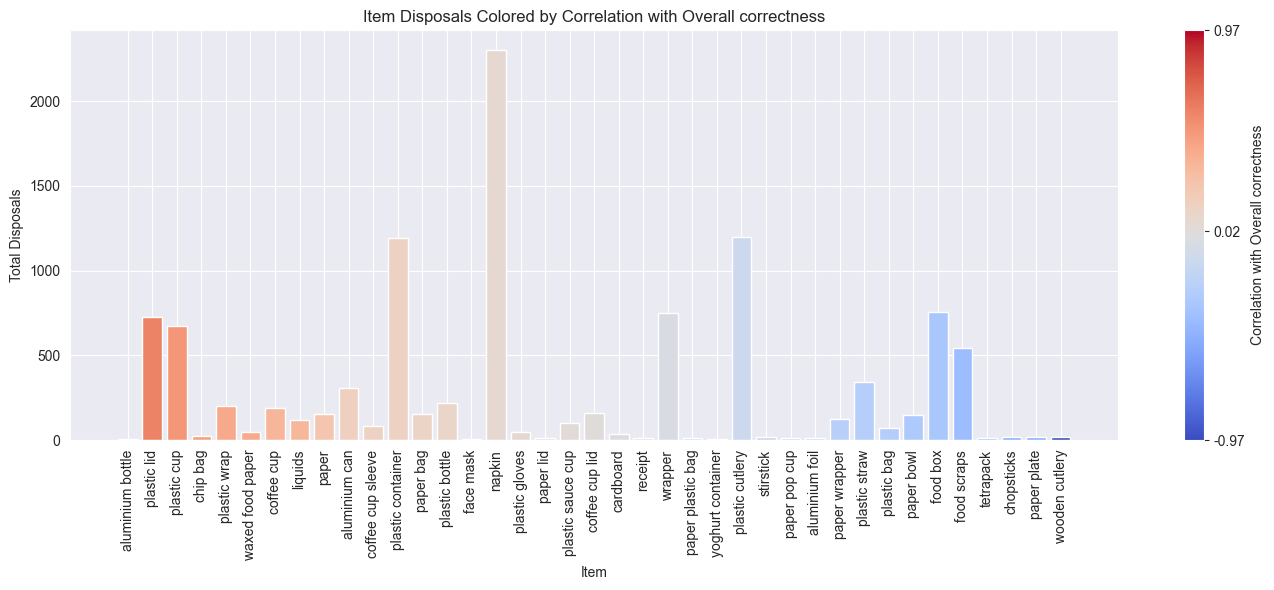

In [55]:
summary = item_daily.groupby('Item').agg({
    'Correlation': 'first',
    'Disposals': 'sum'
}).reset_index()

# Drop rows where correlation is 0 or NaN
summary = summary[(summary['Correlation'] != 0) & (~summary['Correlation'].isna())]

# Sort by correlation
summary = summary.sort_values('Correlation', ascending=False)

# Normalize disposals for colormap
norm = plt.Normalize(vmin=summary['Correlation'].min(), vmax=summary['Correlation'].max())
cmap = plt.cm.coolwarm
colors = cmap(norm(summary['Correlation']))

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(summary['Item'], summary['Disposals'], color=colors)
ax.set_xticks(range(len(summary['Item'])))
ax.set_xticklabels(summary['Item'], rotation=90)
ax.set_xlabel('Item')
ax.set_ylabel('Total Disposals')
ax.set_title('Item Disposals Colored by Correlation with Overall correctness')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, label='Correlation with Overall correctness', ax=ax)
cbar.set_ticks([summary['Correlation'].min(), summary['Correlation'].median(), summary['Correlation'].max()])
cbar.set_ticklabels([f"{summary['Correlation'].min():.2f}", f"{summary['Correlation'].median():.2f}", f"{summary['Correlation'].max():.2f}"])

plt.tight_layout()
plt.show()

Below is a simpler version of the above plot that makes it easier to take in the information and is more suitable for an article.

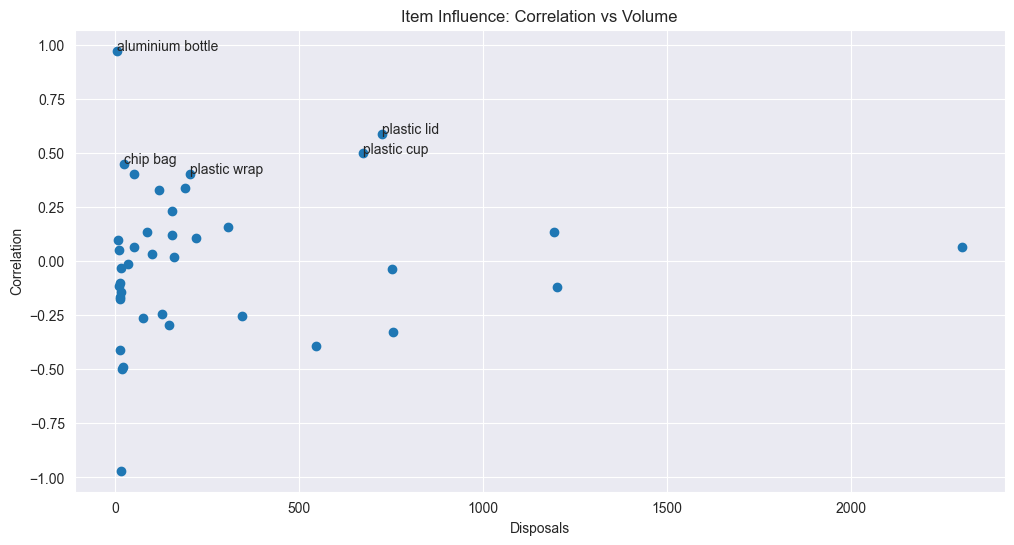

In [70]:
# Make a scatter plot of item disposals vs correlation score
plt.figure(figsize=(12, 6))
plt.scatter(summary['Disposals'], summary['Correlation'])
plt.xlabel('Disposals')
plt.ylabel('Correlation')
plt.title('Item Influence: Correlation vs Volume')
# Annotate top influential points
for _, row in summary.nlargest(5, 'Correlation').iterrows():
    plt.annotate(row['Item'], (row['Disposals'], row['Correlation']))
plt.grid(True)
plt.show()

This plot above uses the height of each bar to indicate the volume of disposals of each item while the color indicates the correlation value according to the scale to the right. When items don't have a high volume of disposals, their correlation value does not mean much as the number of instances used in calculation is very small. For this reason, we should not consider any of these items to be highly influential on the overall correctness. Instead, we look for items that have fairly high volume and relatively high, positive correlation values in order to find items that have the most influence on overall correctness. These criteria lead us to *plastic lids and plastic cups* as the two items with the most influence on overall correctness. According to this metric, it is critical that these items are disposed of correctly (in the recycling) in order to ensure a satisfactory overall correctness rate.

Let's do something very similar, but this time use linear regression to get a regression coefficient for each item. We will be performing regression for each item where we will use the correctness of the item over time to attempt to predict the overall correctness over the same time period.

In [56]:
import statsmodels.api as sm

results_list = []

#Filter for items with at least 10 disposals
item_daily = item_daily[item_daily['Disposals'] >= 10]

for item in item_daily['Item'].unique():
    item_data = item_daily[item_daily['Item'] == item]
    item_data = item_data.merge(daily[['Date', 'correctness']], on='Date', suffixes=('', '_Overall'))
    # Filter out items that have 3 or less data points
    if len(item_data) > 3:
        X = item_data['correctness']
        X = sm.add_constant(X)
        y = item_data['correctness_Overall']
        model = sm.OLS(y, X).fit()
        coef = model.params['correctness']
        std_err = model.bse['correctness']
        results_list.append({'item': item, 'coefficient': coef, 'std_error': std_err})

results_df = pd.DataFrame(results_list).sort_values('coefficient', ascending=False)
print(results_df)


                 item  coefficient  std_error
2   plastic container     0.264223   0.108250
6             wrapper     0.218948   0.094356
5         plastic lid     0.196624   0.079036
14              paper     0.170883   0.076633
3         plastic cup     0.134673   0.054412
13       plastic wrap     0.100511   0.123674
7       aluminium can     0.075661   0.041101
12        food scraps     0.073991   0.172148
10     plastic bottle     0.061784   0.082803
0              napkin     0.050472   0.144923
1            food box     0.011556   0.188652
9           paper bag    -0.005258   0.110875
8          coffee cup    -0.007448   0.075988
4     plastic cutlery    -0.008739   0.156571
11      plastic straw    -0.044279   0.078653


The above table shows all items with their coefficients and standard errors.

Now, we will visualize these results. Note: we will be removing paper bowl from this visual as it is an outlier with an extremely high error.

<Figure size 1200x500 with 0 Axes>

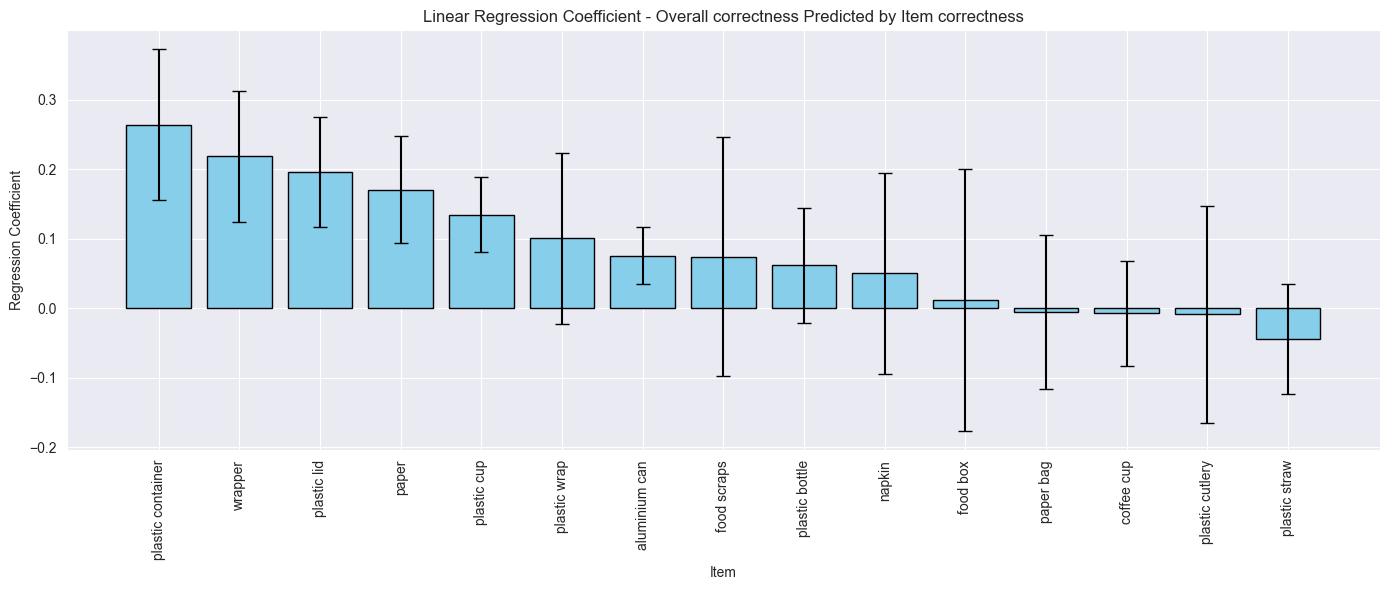

In [57]:
# Drop Paper bowl, it is an extreme outlier
results_df = results_df[results_df['item'] != 'paper bowl']

plt.figure(figsize=(12, 5))

x = results_df['item']
y = results_df['coefficient']
yerr = results_df['std_error']

fig, ax = plt.subplots(figsize=(14, 6))
plt.bar(x, y, yerr=yerr, capsize=5, color='skyblue', edgecolor='black')
ax.set_xticks(range(len(results_df['item'])))
ax.set_xticklabels(results_df['item'], rotation=90)
plt.xlabel('Item')
plt.ylabel('Regression Coefficient')
plt.title('Linear Regression Coefficient - Overall correctness Predicted by Item correctness')
plt.tight_layout()
plt.show()

According to this metric, plastic containers, wrappers, and plastic lids seem to be some of the best predictors of overall correctness. This is interesting as plastic lids are also a strong predictor according to the correlation calculations, but th

Let's try to use weighted least squares regression so that we can weight the values by the number of disposals. The reason we want to do this is that items with a low number of disposals should not be considered highly influential of the overall correctness. Weighting our values will prevent this from happening.

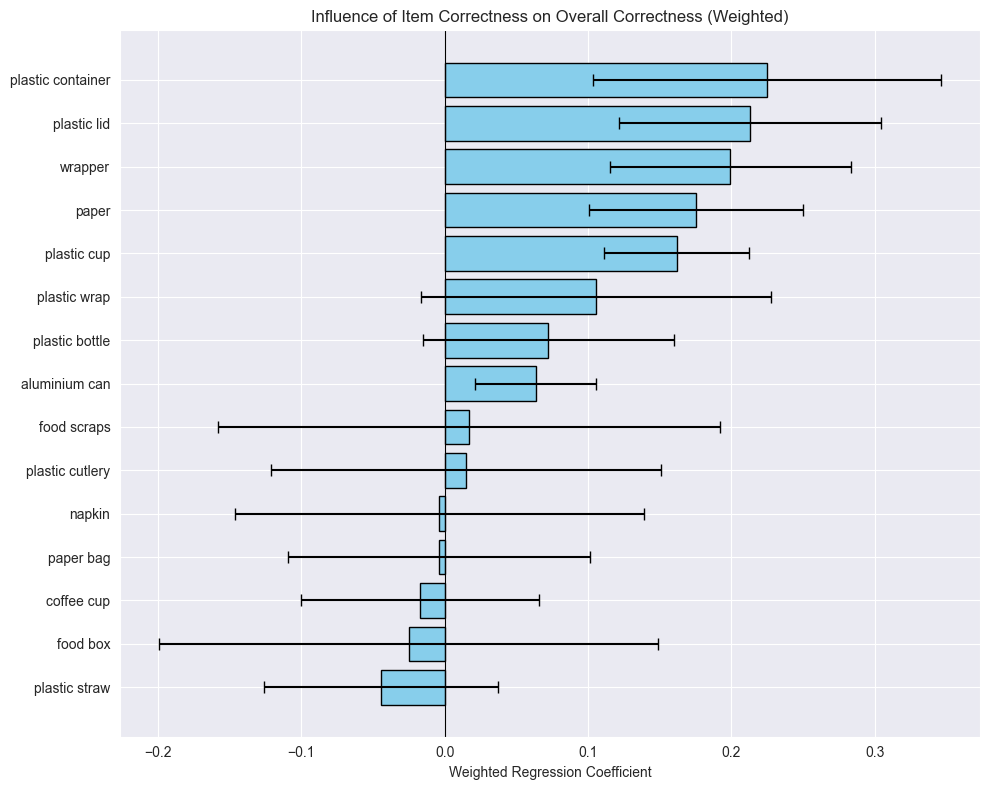

In [71]:
# Store results
results = []

for item in item_daily['Item'].unique():
    item_data = item_daily[item_daily['Item'] == item].merge(
        daily[['Date', 'correctness']], on='Date', suffixes=('', '_Overall')
    )

    if len(item_data) > 3:  # Require at least 4 days of data
        X = sm.add_constant(item_data['correctness'])
        y = item_data['correctness_Overall']
        weights = item_data['Disposals']  # weight by item volume

        model = sm.WLS(y, X, weights=weights).fit()

        results.append({
            'Item': item,
            'Coefficient': model.params['correctness'],
            'Std_Error': model.bse['correctness']
        })

# Create DataFrame of results
results_df = pd.DataFrame(results).sort_values('Coefficient', ascending=True)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(
    results_df['Item'],
    results_df['Coefficient'],
    xerr=results_df['Std_Error'],
    capsize=4,
    color='skyblue',
    edgecolor='black'
)
plt.axvline(0, color='black', linewidth=0.8)
plt.xlabel('Weighted Regression Coefficient')
plt.title('Influence of Item Correctness on Overall Correctness (Weighted)')
plt.tight_layout()
plt.show()

This graph combined with the scatter plot above shows us that plastic cups and lids are some of the most influential items for overall correctness since both these items fall within the top 5 of both metrics. This tells us that it is critical these items are disposed of correctly if we want to see higher correctness rates.

### Disposal Confusion Matrix
Next, let's put together a confusion matrix of all disposals in order to get a better understanding of the current state of waste sorting across all Oscar devices.

Precision: 0.57
Recall: 0.30
correctness: 0.67
F1 Score: 0.40


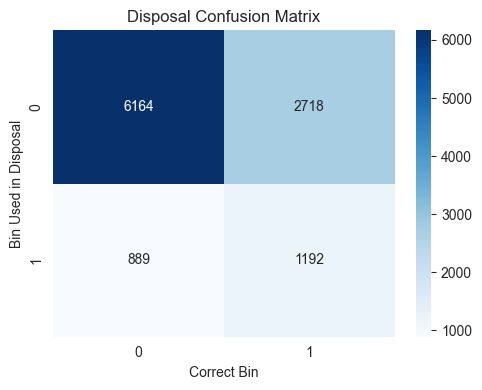

In [58]:
#TN
garbage_in_garbage = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
#FN
garbage_in_recycling = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] > 0)]['Disposals'].sum()
#TP
recycling_in_recycling = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
#FP
recycling_in_garbage = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] > 0)]['Disposals'].sum()

confusion_matrix = np.array([[garbage_in_garbage, recycling_in_garbage],[garbage_in_recycling, recycling_in_recycling]])


#Calculate Metrics
precision = recycling_in_recycling / (recycling_in_recycling + garbage_in_recycling)
recall = recycling_in_recycling / (recycling_in_recycling + recycling_in_garbage)
correctness = (recycling_in_recycling + garbage_in_garbage) / (recycling_in_recycling + garbage_in_recycling + recycling_in_garbage + garbage_in_garbage)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"correctness: {correctness:.2f}")
print(f"F1 Score: {f1_score:.2f}")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Disposal Confusion Matrix')
plt.xlabel('Correct Bin')
plt.ylabel('Bin Used in Disposal')
plt.tight_layout()
plt.show()

The confusion matrix above clearly shows that the most common waste sorting incorrectness is placing non-recyclable items in the recycling bin. This outcome occurs more than three times as often as recycling being placed in the garbage bin. With this being said, let's break down the context and implications of each of the four possible outcomes in this matrix.

* *Recylable placed in Recycling* - Correct disposal, no negative implications
* *Recyclable placed in Trash* - The other items in the bin are unaffected, but this was a missed opportunity to recycle
* *Trash placed in Trash* - Correct disposal, no negative implications
* *Trash placed in Recycling* - Depending on the item disposed, other items in the recycling bin can potentially get soiled, ruining their potential to one day be recycled.

Based on this analysis, placing trash in the recycling definitely has a harsher negative effect than placing recycling in the trash. For this reason, it is critical that the fairly common occurrence of trash being placed in the recycling is reduced in order to improve sustainability of waste disposal on campus.

Moving on to the metrics printed above the table, here is what they each mean in context:
* Precision = 0.57 -> Of all the items in the recycling bin, only 57% are actually recyclable items
* Recall = 0.30 -> Of all the recyclable items, only 30% of them were placed in the recycling bin
* correctness = 0.67 -> 67% of all items were sorted correctly
* F1 Score = 0.40 -> A combination of precision and recall comes out to 0.4, so neither precision nor recall are especially strong

In conclusion, the biggest struggle in waste sorting on campus in Oscar devices is placing recyclable items in their proper place

### Item Association Rule Mining
In this final section, I will use a technique known as association rule mining to find which items frequently are disposed of in the same device, day, and bin. Then, I will filter through those "association rules" in order to find which pairs of contaminating items (items that belong in different bins) are associated. This will allow us to see which items may be the most problematic and why.

In [59]:
disposals['Transaction'] = (
   disposals['Date'].astype(str) + '_' +
   disposals['Device'] + '_' +
   disposals['Bin']
)


# Step 2: Create a basket matrix (transactions × items)
basket = (
   disposals
   .groupby(['Transaction', 'Item'])['Disposals']
   .sum()
   .unstack()
   .fillna(0)
)


# Step 3: Binarize the data (presence = 1, absence = 0)
basket = (basket > 0).astype(bool)


basket = basket.loc[:, basket.sum() >= 5]




frequent_itemsets = apriori(basket, min_support=0.1, max_len=2, use_colnames=True)


# Step 5: Generate association rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.75)


# Display top rules
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).to_csv('rules.csv', index=False)



,antecedents,consequents,support,confidence,lift
5,(banana peel),(liquids),0.123810,0.764706,2.549020
16,(coffee cup),(coffee cup lid),0.404762,0.904255,2.182685
15,(coffee cup lid),(coffee cup),0.404762,0.977011,2.182685
29,(coffee cup sleeve),(coffee cup lid),0.223810,0.824561,1.990321
160,(waxed food paper),(plastic wrap),0.109524,0.851852,1.987654
37,(waxed food paper),(coffee cup lid),0.104762,0.814815,1.966794
4,(banana peel),(food scraps),0.152381,0.941176,1.956902
17,(coffee cup sleeve),(coffee cup),0.228571,0.842105,1.881299
12,(banana peel),(plastic wrap),0.128571,0.794118,1.852941
3,(banana peel),(coffee cup lid),0.123810,0.764706,1.845842


This table above shows the top 10 association rules by lift. Here are the definitions of the different terms used above:

* Antecedents - The item being observed
* Consequents - The item that we predict will occur given the antecedent
* Support - How frequently an itemset appears in the dataset
* Confidence - The strength of association between the two items. Higher confidence means the association rule is a more reliable predictor
* Lift - Another measure of the strength of association. A lift of X means that the occurrence of the consequent given the antecedent is X times more likely than random chance

Lift is commonly used as the metric for determining the strongest associations and that is what I will be using to accomplish just that. Let's filter all rules to find ones where a pair of contaminating items are present in the same rule.

In [60]:
#Find association rules with two contaminants

results = pd.DataFrame()

for index, row in rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])

    for a in antecedents:
        for b in consequents:
            if (a in trash_items and b in recycling_items) or (b in trash_items and a in recycling_items):
                results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

results = results.drop_duplicates()
contam_associates_top_10 = results[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)
display(contam_associates_top_10)

,antecedents,consequents,support,confidence,lift
6,(coffee cup lid),(coffee cup),0.404762,0.977011,2.182685
7,(coffee cup),(coffee cup lid),0.404762,0.904255,2.182685
15,(coffee cup sleeve),(coffee cup lid),0.223810,0.824561,1.990321
1,(banana peel),(coffee cup),0.133333,0.823529,1.839800
13,(waxed food paper),(coffee cup),0.104762,0.814815,1.820331
10,(plastic bag),(coffee cup),0.152381,0.780488,1.743643
26,(paper bag),(food scraps),0.257143,0.818182,1.701170
8,(coffee cup),(food scraps),0.342857,0.765957,1.592585
49,(plastic bag),(plastic container),0.185714,0.951220,1.560595
2,(banana peel),(plastic container),0.152381,0.941176,1.544118


Now that we have the top 10 rules containing contaminating items, let's format the output in a more readable way by printing our results in plain English text

In [61]:
def isTrash(item):
    return(item in trash_items)

for index, row in contam_associates_top_10.iterrows():
    output = "If "
    for i in list(row['antecedents']):
        output += i + " (" + ("Trash" if isTrash(i) else "Recycling") + ") "
    output += "is present in a single disposal, "
    for i in list(row['consequents']):
        output += i + " (" + ("Trash" if isTrash(i) else "Recycling") + ") "
    output += "is likely also present."

    display(Markdown((output)))

If coffee cup lid (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If coffee cup (Recycling) is present in a single disposal, coffee cup lid (Trash) is likely also present.

If coffee cup sleeve (Recycling) is present in a single disposal, coffee cup lid (Trash) is likely also present.

If banana peel (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If waxed food paper (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If plastic bag (Trash) is present in a single disposal, coffee cup (Recycling) is likely also present.

If paper bag (Recycling) is present in a single disposal, food scraps (Trash) is likely also present.

If coffee cup (Recycling) is present in a single disposal, food scraps (Trash) is likely also present.

If plastic bag (Trash) is present in a single disposal, plastic container (Recycling) is likely also present.

If banana peel (Trash) is present in a single disposal, plastic container (Recycling) is likely also present.

The above are the top ten strongest contaminating association rules.
Although it should not be a surprise, coffee cup lids appear to be the most problamatic item as they are present in the top 3 contamination associations. With coffee cup lids being labeled as trash and the rest of the coffee cup (the sleeve and the cup itself) being recyclables, it is easy to see how this could generate a lot of contamination. For this reason, it could make a very large difference in the overall contamination volume if recyclable coffee cup lids were used instead.
The other biggest issue beyond this seems to be failure to separate food scraps from recyclable food containers. A great way to address this and promote less contamination in the waste stream could be to advertise scraping or dumping food waste into the trash before disposing of containers in the recycling. Simple signage sharing this guidance on signs near waste containers as well as on the screens of the Oscar devices could go a long way in promoting better wate sorting.